In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7nx22bdg
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7nx22bdg
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=f5ae4f81d06a024aae3fb0fbf0bc04cb948b4dea5a4001393c624d516bab4c0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ednuro9y/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
! pip install open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.4 MB/s eta 0:00:00


In [ ]:
!wget -c http://images.cocodataset.org/zips/val2017.zip
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2024-02-25 12:18:36--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.204.81, 3.5.29.59, 3.5.30.44, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.204.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  46.9MB/s    in 17s     

2024-02-25 12:18:53 (44.7 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2024-02-25 12:18:53--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.165, 3.5.28.94, 16.182.75.57, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===========

In [ ]:
!unzip val2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

In [ ]:
!unzip annotations_trainval2017.zip

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
import torch
from torchvision.datasets import CocoCaptions
import torch.utils.data as dutils
from typing import List
import clip

In [ ]:
import gdown
gdown.download(id="1ooVVPxB-tvptgmHlIMMFGV3Cg-IrhbRZ", output='negclip.pt', quiet=False)

### If you want to use CLIP for retrieval, run the next cell. However, if you want to use NegCLIP for retrieval, run the cell after that.

In [ ]:
coco_root = "val2017"
coco_ann_file = "annotations/captions_val2017.json"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model, transform = clip.load("ViT-B/32")
model.to(device).eval()

dataset = CocoCaptions(
    root=coco_root,
    annFile=coco_ann_file,
    transform=transform,
    # Note: almost all images have 5 captions, but 12/5000 have 6, and 1/5000 has 7 - I ignore these few extra captions.
    target_transform=lambda texts: clip.tokenize(texts[:5])
)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 60.0MiB/s]


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [ ]:
import open_clip
def get_model(model_name, device, root_dir):
    """
    Helper function that returns a model and a potential image preprocessing function.
    """
    #download the wheights from : https://github.com/mertyg/vision-language-models-are-bows
    if "negclip" in model_name:

        path = '/content/negclip.pt'
        model, _, image_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained=path, device=device)
        model = model.eval()
        # clip_model = CLIPWrapper(model, device)
        return model, image_preprocess

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model, transform = get_model(model_name="negclip", device="cuda", root_dir='')
model.to(device).eval()

dataset = CocoCaptions(
    root=coco_root,
    annFile=coco_ann_file,
    transform=transform,
    # Note: almost all images have 5 captions, but 12/5000 have 6, and 1/5000 has 7 - I ignore these few extra captions.
    target_transform=lambda texts: clip.tokenize(texts[:5])
)

In [ ]:
k_vals=[1, 5, 10, 50]

In [ ]:
# Encodes all text and images in a dataset
from tqdm import tqdm
def encode_dataset(clip, dataset: dutils.Dataset, batch_size = 16):
    with torch.no_grad():
        # image_to_text_map[i] gives the corresponding text indices for the ith image
        #  (as there are multiple pieces of text for each image)
        image_to_text_map = []

        # text_to_image_map[i] gives the corresponding image index for the ith text
        text_to_image_map = []

        dataloader = dutils.DataLoader(dataset, batch_size=batch_size, shuffle=False)

        image_encodings = []
        text_encodings = []

        text_index = 0
        image_index = 0

        for images, text in tqdm(dataloader):
            images = images.to(device)
            text = text.to(device)

            # text has shape B x 5 x 77
            batch_size, captions_per_image, _ = text.shape

            # Update text_to_image_map and image_to_text_map for this batch
            for i in range(batch_size):
                # the next image corresponds to text captions [text_index ... text_index + captions_per_image - 1]
                text_indices = list(range(text_index, text_index + captions_per_image))
                image_to_text_map.append(text_indices)
                text_index += captions_per_image

                # Each of the next captions_per_image text captions correspond to the same image
                text_to_image_map += [image_index] * captions_per_image
                image_index += 1

            # B x 5 x 77 -> (B*5) x 77
            text = torch.flatten(text, start_dim=0, end_dim=1)

            image_encodings.append(clip.encode_image(images))
            text_encodings.append(clip.encode_text(text))

        image_encodings = torch.cat(image_encodings)
        text_encodings = torch.cat(text_encodings)
        text_to_image_map = torch.LongTensor(text_to_image_map).to(device)
        image_to_text_map = torch.LongTensor(image_to_text_map).to(device)

        # Normalise encodings
        image_encodings = image_encodings / image_encodings.norm(dim=-1, keepdim=True)
        text_encodings = text_encodings / text_encodings.norm(dim=-1, keepdim=True)

        return image_encodings, text_encodings, text_to_image_map, image_to_text_map

In [ ]:
def recall_at_k(clip, dataset: dutils.Dataset, k_vals: List[int], batch_size: int):
    print("Encoding all data...")
    image_encodings, text_encodings, text_to_image_map, image_to_text_map = encode_dataset(clip, dataset, batch_size=batch_size)

    num_text = text_encodings.shape[0]
    num_im = image_encodings.shape[0]
    captions_per_image = image_to_text_map.shape[1]

    # text-to-image recall
    print("Text-to-image recall...")

    dist_matrix = text_encodings @ image_encodings.T  # dist_matrix[i] gives logits for ith text

    # Note: this matrix is pretty big (5000 x 25000 with dtype float16 = 250MB)
    #  torch.argsort runs out of memory for me (6GB VRAM) so I move to CPU for sorting
    dist_matrix = dist_matrix.cpu()

    # Sort in descending order; first is the biggest logit
    inds = torch.argsort(dist_matrix, dim=1, descending=True)
    inds = inds.to(device)

    text_to_image_recall = []

    for k in k_vals:
        # Extract top k indices only
        topk = inds[:, :k]

        # Correct iff one of the top_k values equals the correct image (as given by text_to_image_map)
        correct = torch.eq(topk, text_to_image_map.unsqueeze(-1)).any(dim=1)

        num_correct = correct.sum().item()
        text_to_image_recall.append(num_correct / num_text)


    # image-to-text recall
    print("Image-to-text recall...")
    dist_matrix = dist_matrix.T  # dist_matrix[i] gives logits for the ith image

    # Sort in descending order; first is the biggest logit
    inds = torch.argsort(dist_matrix, dim=1, descending=True)
    inds = inds.to(device)

    image_to_text_recall = []

    for k in k_vals:
        # Extract top k indices only
        topk = inds[:, :k]

        correct = torch.zeros((num_im,), dtype=torch.bool).cuda()

        #  For each image, check whether one of the 5 relevant captions was retrieved
        # Check if image matches its ith caption (for i=0..4)
        for i in range(captions_per_image):
            contains_index = torch.eq(topk, image_to_text_map[:, i].unsqueeze(-1)).any(dim=1)
            correct = torch.logical_or(correct, contains_index)

        num_correct = correct.sum().item()
        image_to_text_recall.append(num_correct / num_im)#

    print("Done.")
    return text_to_image_recall, image_to_text_recall




In [ ]:
t2i, i2t = recall_at_k(model, dataset, k_vals=k_vals, batch_size=16)

print("Text-to-image Recall@K")
for k, x in zip(k_vals, t2i):
    print(f" R@{k}: {100*x:.2f}%")

print("Image-to-text Recall@K")
for k, x in zip(k_vals, i2t):
    print(f" R@{k}: {100*x:.2f}%")

Encoding all data...


100%|██████████| 313/313 [02:31<00:00,  2.07it/s]


Text-to-image recall...
Image-to-text recall...
Done.
Text-to-image Recall@K
 R@1: 41.56%
 R@5: 68.69%
 R@10: 78.92%
 R@50: 95.23%
Image-to-text Recall@K
 R@1: 56.86%
 R@5: 80.72%
 R@10: 88.08%
 R@50: 98.08%


In [ ]:
t2i, i2t = recall_at_k(model, dataset, k_vals=k_vals, batch_size=16)

print("Text-to-image Recall@K")
for k, x in zip(k_vals, t2i):
    print(f" R@{k}: {100*x:.2f}%")

print("Image-to-text Recall@K")
for k, x in zip(k_vals, i2t):
    print(f" R@{k}: {100*x:.2f}%")

Encoding all data...


100%|██████████| 313/313 [01:34<00:00,  3.31it/s]


Text-to-image recall...
Image-to-text recall...
Done.
Text-to-image Recall@K
 R@1: 30.37%
 R@5: 54.75%
 R@10: 66.10%
 R@50: 89.28%
Image-to-text Recall@K
 R@1: 49.92%
 R@5: 74.94%
 R@10: 83.30%
 R@50: 95.82%


In [ ]:
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
input_points = [[[450, 600]]]  # 2D location of a window in the image

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q roboflow supervision
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-e52044ov
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-e52044ov
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=376e1f29e7db228b73d15274f44f7f94adf50193da2a4414239aecb28d2aeb80
  Stored in directory: /tmp/pip-ephem-wheel-cache-wxazd3n8/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from segment_anything import sam_model_registry

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint='/content/sam_vit_h_4b8939.pth')
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [ ]:
import cv2
from segment_anything import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(sam)

image_bgr = cv2.imread('/content/sam.png')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
result = mask_generator.generate(image_rgb)

In [ ]:
import supervision as sv
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
# mask_annotator = sv.MaskAnnotator(color_map = "index")
detections = sv.Detections.from_sam(result)
annotated_image = mask_annotator.annotate(image_bgr, detections)

array([[[197, 148, 110],
        [203, 161, 127],
        [226, 120, 143],
        ...,
        [227, 124, 150],
        [227, 124, 150],
        [199, 162, 130]],

       [[191, 139,  96],
        [199, 154, 116],
        [224, 116, 138],
        ...,
        [226, 121, 146],
        [226, 121, 145],
        [196, 155, 121]],

       [[191, 142, 100],
        [226, 118, 141],
        [224, 117, 140],
        ...,
        [228, 124, 148],
        [227, 123, 148],
        [199, 160, 127]],

       ...,

       [[174, 108, 150],
        [120,  54,  95],
        [ 92,  26,  68],
        ...,
        [151, 157, 163],
        [120, 130, 140],
        [ 92, 105, 124]],

       [[212, 215, 216],
        [150,  84, 126],
        [ 92,  25,  66],
        ...,
        [ 56,  61,  70],
        [ 30,  34,  47],
        [ 51,  66,  92]],

       [[231, 233, 233],
        [230, 231, 231],
        [154,  88, 130],
        ...,
        [148, 109, 102],
        [144, 147, 155],
        [171, 178, 190]]], dtype=uint8)
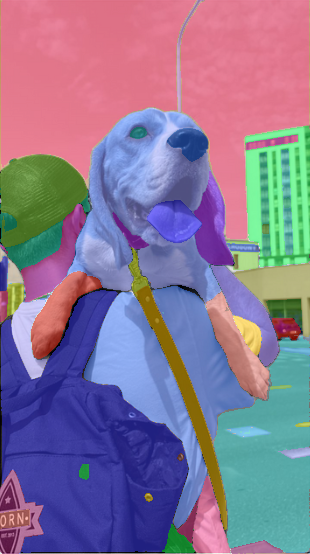

In [ ]:
annotated_image

In [ ]:
import cv2
from segment_anything import SamPredictor
import numpy as np

mask_predictor = SamPredictor(sam)

image_bgr = cv2.imread('/content/sam.png')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
mask_predictor.set_image(image_rgb)

box = np.array([70, 247, 626, 926])
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

In [ ]:
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [ ]:
scores

array([0.4235396 , 0.6937122 , 0.75649726], dtype=float32)

In [ ]:
logits

array([[[-17.900234 , -19.284655 , -18.495207 , ..., -17.350298 ,
         -17.11078  , -16.742615 ],
        [-21.115997 , -19.154057 , -21.53112  , ..., -18.897387 ,
         -20.996216 , -17.129412 ],
        [-18.868856 , -19.448696 , -18.578646 , ..., -17.993488 ,
         -18.232533 , -17.02073  ],
        ...,
        [-17.136255 , -15.348465 , -14.733218 , ..., -16.349413 ,
         -17.517048 , -13.402241 ],
        [-16.891094 , -18.408245 , -14.761387 , ..., -18.6398   ,
         -15.6743555, -14.483795 ],
        [-16.928465 , -14.971047 , -13.800789 , ..., -15.936286 ,
         -17.150127 , -12.564693 ]],

       [[-19.741512 , -21.145374 , -21.042809 , ..., -24.671501 ,
         -24.185825 , -22.788193 ],
        [-23.338356 , -21.691536 , -23.947477 , ..., -25.57613  ,
         -27.487207 , -22.137724 ],
        [-21.353941 , -22.499039 , -20.687492 , ..., -23.707008 ,
         -25.321854 , -22.761187 ],
        ...,
        [-19.72662  , -20.89099  , -20.185738 , ..., -